# Install Libraries

In [1]:
!pip install pillow
!nvidia-smi

Tue Feb 15 01:32:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download Dataset

In [2]:
DATASET_FILE = "scalene_triangle_0_355_step5_randomdisp_5000randomtest.zip"
DATASET_DIR = "scalene_triangle_0_355_step5_randomdisp_5000randomtest"
!rm -rf "$DATASET_DIR"
!curl -L https://github.com/joshbarrass/Y4ProjectNotebooks/raw/master/$DATASET_FILE > "$DATASET_FILE"
!unzip -d "$DATASET_DIR" "$DATASET_FILE" > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   188  100   188    0     0   1167      0 --:--:-- --:--:-- --:--:--  1175
100   199  100   199    0     0    742      0 --:--:-- --:--:-- --:--:--  5685
100 19.6M  100 19.6M    0     0  25.7M      0 --:--:-- --:--:-- --:--:-- 25.7M


# Define Helper Functions

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.spatial.transform import Rotation as R

D6_SHAPE = (3, 2)

def normalise(x):
    return x / np.linalg.norm(x)

def from_SO3_to_6D(SO3):
    """Convert an SO(3) rotation matrix to a 6D internal representation."""
    return SO3[:,:2]

def from_6D_to_SO3(D6):
    """Convert a 6D internal representation to an SO(3) rotation matrix."""
    b1 = normalise(D6[:,0])
    b2 = normalise(D6[:,1] - np.dot(b1, D6[:,1])*b1)
    b3 = np.cross(b1, b2)
    return np.array([b1, b2, b3]).T

def tf_6D_to_SO3(D6):
  """tensorflow-compatible conversion from 6D to SO(3). Used in the D6Convert layer."""
  a1 = D6[:,:,0]
  a2 = D6[:,:,1]
  b1 = tf.math.l2_normalize(a1, axis=-1)
  b2 = tf.math.l2_normalize(a2 - tf.reduce_sum(b1*a2)*b1, axis=-1)
  b3 = tf.linalg.cross(b1, b2)
  return tf.stack([b1, b2, b3], axis=2)

class D6Convert(layers.Layer):
  def call(self, inputs):
    target_input_shape = tf.TensorShape(((None,) + D6_SHAPE))
    if not inputs.shape.is_compatible_with(target_input_shape):
      raise TypeError("inputs to D6Convert should have shape {}, not {}".format(target_input_shape, inputs.shape))
    return tf_6D_to_SO3(inputs)

### DEPRECATED: Returns wrong value
# def SO3_distance(M1, M2):
#  """Returns the distance between two SO3 matrices in degrees"""
#  R = M1 * np.linalg.inv(M2)
#  return np.rad2deg(np.arccos((np.trace(R)-1)/2))

# Implement Quaternion SO(3) Distance

In [4]:
# quaternion [x, y, z, w]: w + xi + yj + zk
# this is the format outputted by scipy
def SO3_distance(M1, M2):
  """Returns the angle between two SO3 matrices in degrees.

  This is done by converting the matrices to quaternions and multiplying the
  conjugate of one with the other. The scalar part of the resulting quaternion
  is then cos(theta/2). The expression has been simplified to calculate only the
  scalar part."""
  x1, y1, z1, w1 = R.from_matrix(M1).as_quat()
  x2, y2, z2, w2 = R.from_matrix(M2).as_quat()
  angle = np.rad2deg(2*np.arccos(w1*w2 + x1*x2 + y1*y2 + z1*z2))
  # maximum rotation away from a given angle is 180 degrees
  # any further and you reduce the angle by rotating the opposite direction
  # some edge cases produce angles > 180 degrees, so rectify these
  if angle > 180:
    return 360 - angle
  return angle

### TEST SO3_distance
for i in range(100):
  test_angle1, test_angle2 = np.random.uniform(0, 180, 2) # max difference should be 180, as > 180 is no longer the shortest angle
  testM1 = R.from_euler("zyx", [test_angle1, 0, 0], degrees=True).as_matrix()
  testM2 = R.from_euler("zyx", [test_angle2, 0, 0], degrees=True).as_matrix()
  test_true_angle = abs(test_angle1-test_angle2)
  test_angle = abs(SO3_distance(testM1, testM2))
  np.testing.assert_approx_equal(test_angle, test_true_angle, 5)

In [5]:
SO31 = R.from_euler("zyx",[3, 2, 1]).as_matrix()
D61 = from_SO3_to_6D(SO31)
SO32 = R.from_euler("zyx",[0.5, 1, 1.2]).as_matrix()
D62 = from_SO3_to_6D(SO32)
print("True:", SO31, "\n", SO32, sep="")
print("np1:", from_6D_to_SO3(D61))
print("np2:", from_6D_to_SO3(D62))
print("tf:", tf_6D_to_SO3(np.array([D61, D62])))

True:[[ 0.41198225  0.05872664  0.90929743]
 [-0.68124272 -0.64287284  0.35017549]
 [ 0.60512725 -0.76371834 -0.2248451 ]]
[[ 0.47415988 -0.25903472  0.84147098]
 [ 0.86199739 -0.05800686 -0.50358287]
 [ 0.17925654  0.96412459  0.19578273]]
np1: [[ 0.41198225  0.05872664  0.90929743]
 [-0.68124272 -0.64287284  0.35017549]
 [ 0.60512725 -0.76371834 -0.2248451 ]]
np2: [[ 0.47415988 -0.25903472  0.84147098]
 [ 0.86199739 -0.05800686 -0.50358287]
 [ 0.17925654  0.96412459  0.19578273]]
tf: tf.Tensor(
[[[ 0.41198225  0.05872664  0.90929743]
  [-0.68124272 -0.64287284  0.35017549]
  [ 0.60512725 -0.76371834 -0.2248451 ]]

 [[ 0.47415988 -0.25903472  0.84147098]
  [ 0.86199739 -0.05800686 -0.50358287]
  [ 0.17925654  0.96412459  0.19578273]]], shape=(2, 3, 3), dtype=float64)


# Create Image Centering Function

In [6]:
import numpy as np
from scipy import ndimage
from PIL import Image
def centre_image(a: np.ndarray, target_centre=(0,0), interp=0):
  """Centres a single-channel image using centre of mass.
  
  Target centre is defined such that (x=0,y=0) is the centre of the image.
  Increasing x moves the centre to the right, increasing y moves the centre
  down."""
  if len(a.shape) == 2:
    a = a.reshape((1,) + a.shape)

  # determine all centres of mass
  # TODO: can potentially take advantage of labelling to remove "noise islands"
  if len(a.shape) == 3:
    COM = np.zeros((a.shape[0], 2))
    for i in range(a.shape[0]):
      COM[i] = ndimage.measurements.center_of_mass(a[i])
  else:
    raise TypeError("a should be either 2D image or an array of 2D")

  output = np.zeros(a.shape)

  # translate COM to centre of image
  for i in range(a.shape[0]):
    im = a[i]
    final_target = (im.shape[0]/2 + target_centre[0],
                     im.shape[1]/2 + target_centre[1])
    # use affine transform with a=1, e=1, i=1, c=x, f=y to translate
    translation = (COM[i][0] - final_target[0], COM[i][1] - final_target[1])
    transform = np.array([[1, 0, translation[0]],
                          [0, 1, translation[1]],
                          [0, 0, 1]])
    output[i] = ndimage.affine_transform(im, transform, order=interp, mode="wrap")
  
  return output


# Load and Pre-Process Training Data

In [7]:
import os
import random
from scipy.spatial.transform import Rotation as R
from PIL import ImageFilter
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.preprocessing.image as impreproc

def polar_to_cartesian(r, theta):
  r = np.abs(r)
  return r*np.cos(theta), r*np.sin(theta)

# https://stackoverflow.com/a/4602224
# Licensed CC BY-SA 3.0
def combined_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

## onload functions. Applied directly to a PIL Image. Take the Image as their
## only argument, and return a single Image.

def onload_MeanResizeImage(target_size):
  """Returns an onload function to resize the image to the target size using
  mean resizing via PIL."""
  def MeanResizeImage(im):
    return im.resize(target_size)
  return MeanResizeImage

def onload_MedianResizeImage(target_size):
  """Returns an onload function to resize the image to the target size using
  median resizing. Only works when the old dimensions are exactly divisible by
  the new dimensions."""
  def MedianResizeImage(im):
    a = np.array(im)
    assert len(a.shape) == 2 # assert 2D image
    assert len(target_size) == 2
    old_w, old_h = a.shape
    new_w, new_h = target_size
    # assert dimensions are divisible
    chunk_w, rem = divmod(old_w, new_w)
    assert rem == 0
    chunk_h, rem = divmod(old_h, new_h)
    assert rem == 0

    # construct the target and intermediate shapes
    target_shape = target_size + (chunk_w, chunk_h)
    inter_shape = (target_shape[0], target_shape[2], target_shape[1], target_shape[3])

    # chunk the image
    a = a.reshape(inter_shape).swapaxes(1, 2)
    
    # flatten the final dimension and apply median
    a = a.reshape(target_size + (chunk_w*chunk_h,))
    a = np.median(a, axis=-1).astype(a.dtype)

    return Image.fromarray(a)
  return MedianResizeImage
    
def onload_GaussianBlur(radius):
  """Returns an onload function to blur the image."""
  image_filter = ImageFilter.GaussianBlur(radius=radius)
  def GaussianBlur(im):
    return im.filter(image_filter)
  return GaussianBlur

def onload_SEMNoise(gauss=2, poisson=5):
  """Returns an onload function that approximates SEM noise and adds it to the
  image."""
  def SEMNoise(im):
    # convert the image to an array for ease
    # use float32 for precision and convert back to int at the end
    a = np.array(im, dtype="float")

    # generate a flat array of N(0,1) numbers and reshape to match the image
    rand = np.random.normal(loc=0.0, scale=1.0, size=np.prod(a.shape)).reshape(a.shape)

    # apply the noise as in https://doi.org/10.1016/j.mee.2019.111051
    noised = a + (gauss + poisson*np.sqrt(a))*rand

    # scale the image to the appropriate range
    final = noised - np.min(noised)
    final /= np.max(final)
    final *= 255

    # round to nearest pixel value and convert back to PIL
    a_prime = final.round().astype("uint8")
    return Image.fromarray(a_prime, "L")
  return SEMNoise


## preproc functions. Receive the complete x and y data arrays, and should
## return complete x and y data arrays. Augmentation can be performed at
## this stage.
## These functions are not guaranteed to be pure! If you do not want to modify
## the original array in these functions, make a copy of the array at the start
## of your function.

def preproc_Normalise():
  """Returns a preproc function that will divide all data by 255 to normalise it"""
  def Normalise(xdata, ydata):
    return xdata/255., ydata
  return Normalise

## TODO: fix this -- data is incorrect when this is used
#def preproc_Centre(interpolation_order=0):
#  """Returns a preproc function that will centre all images as best as possible.
#  Can optionally utilise interpolation (should only be used for debugging)"""
#  def Centre(xdata, ydata):
#    return centre_image(xdata.reshape(xdata.shape[:-1]),
#                        interp=interpolation_order).reshape(xdata.shape), ydata
#  return Centre

def preproc_Centre(interpolation_order=0):
  """Returns a preproc function that will centre all images as best as possible.
  Can optionally utilise interpolation (should only be used for debugging)"""
  def Centre(xdata, ydata):
    newxdata = np.zeros(xdata.shape, dtype=xdata.dtype)
    for i in range(xdata.shape[0]):
      im = xdata[i]
      newxdata[i] = centre_image(im.reshape(im.shape[:-1]),
                                 interp=interpolation_order).reshape(im.shape)
    return newxdata, ydata
  return Centre

def preproc_CentreAug(sigma, repeats=1):
  """Augment the centring of the image as a pre-processing step. Image will be
  intentionally miscentred following a Gaussian distribution of the given
  sigma. This is repeated a number of times for each image to increase the size
  of the dataset (by default, the size will be the same)."""
  def CentreAug(xdata, ydata):
    length = xdata.shape[0]
    new_length = length*repeats
    newxdata = np.zeros((new_length,) + xdata.shape[1:], dtype=xdata.dtype)
    newydata = np.zeros((new_length,) + ydata.shape[1:], dtype=ydata.dtype)

    for i in range(length):
      im = xdata[i]
      rot = ydata[i]
      for j in range(repeats):
        r = np.random.normal(loc=0, scale=sigma)
        theta = np.random.uniform(low=0, high=2*np.pi)
        newxdata[i*repeats + j] = centre_image(im.reshape(im.shape[:-1]),
                                               target_centre=polar_to_cartesian(r, theta)).reshape(im.shape)
        newydata[i*repeats + j] = rot
    
    return newxdata, newydata
    
  return CentreAug

def preproc_Shuffle():
  """Returns a preproc function that shuffles the order of the data."""
  def Shuffle(xdata, ydata):
    print("shuffling")
    return combined_shuffle(xdata, ydata)
  return Shuffle

def preproc_DynamicRange(max=255):
  """Returns a preproc function that attempts to maximise the dynamic range of
  all images in the dataset. The "max" argument corresponds to the maximum value
  a pixel can take. In a standard image this should be 255, but if the image has
  already been normalised this should be changed to 1."""
  def DynamicRange(xdata, ydata):
    dtype = xdata.dtype
    # find minimum of each image
    # search over all axes except the one that determines the image itself
    min_data = np.min(xdata, axis=(1,2,3))
    # restore the extra axes for proper application to each pixel
    xdata -= min_data.reshape(min_data.shape + (1,1,1))

    # repeat for maximum
    max_data = np.max(xdata, axis=(1,2,3))
    xdata *= max
    xdata /= max_data.reshape(max_data.shape + (1,1,1))

    # validate data
    assert (np.max(xdata) == max).all()
    assert (np.min(xdata) == 0).all()

    # ensure dtype is correct
    return xdata.astype(dtype), ydata
  return DynamicRange

def preproc_BrightnessAug(min=1, max=1, renormalise=True):
  """Returns a preproc function that augments the brightness of the image using
  the image preprocessing functions provided by keras. The function used by
  keras will scale the pixel values back to [0, 255], even if they have already
  been normalised. By setting renormalise=True, the image will be normalised to
  the range [0, 1] again."""
  def BrightnessAug(xdata, ydata):
    for i in range(xdata.shape[0]):
      xdata[i] = impreproc.random_brightness(xdata[i], (min, max))
    if renormalise:
      xdata /= 255.
    return xdata, ydata
  return BrightnessAug

def preproc_LinearShift(m=1, c=0, min=0, max=1):
  """Returns a preproc function that applies a linear transformation to the
  image data, of the form I' = m*I + c. If the data falls below min it will be
  made equal to min, and if it exceeds max it will be made equal to max."""
  def LinearShift(xdata, ydata):
    xdata = m*xdata + c
    xdata[xdata > max] = max
    xdata[xdata < min] = min
    return xdata, ydata
  return LinearShift

def preproc_LinearAug(m=(1,1), c=(0,0), min=0, max=1):
  """Returns a preproc function that applies a linear transformation to the
  image data like LinearShift, but the parameters of this transform will be
  chosen from a uniform distribution in the specified ranges."""
  def LinearAug(xdata, ydata):
    md = np.random.uniform(m[0], m[1], xdata.shape[0])
    cd = np.random.uniform(c[0], c[1], xdata.shape[0])
    # reshape to properly apply to each image
    md = md.reshape(md.shape + (1,1,1))
    cd = cd.reshape(cd.shape + (1,1,1))

    xdata = md*xdata + cd
    xdata[xdata > max] = max
    xdata[xdata < min] = min
    return xdata, ydata
  return LinearAug

class DataLoader(keras.utils.Sequence):
  """Loads images and applies pre-processing and augmentation."""
  def __init__(self, dataset_dir, batch_size=32, onload=[], preproc=[], aug=[]):
    """Inputs:
     - dataset_dir: directory containing the dataset to be loaded.
     - batch_size: batch size of the model.
     - onload: list of functions to be applied on each PIL Image as it is loaded.
     - preproc: list of functions to be applied on the complete data arrays after
                image loading.
     - aug: list of preproc functions to applied on the complete data arrays at
            the beginning of each epoch.
     """
    self.dataset_dir = dataset_dir # storing for reference
    self.batch_size = batch_size

    self.aug = aug

    # find images
    image_files = sorted(os.listdir(dataset_dir))
    total_images = len(image_files)
    print(f"Dataset contains {total_images} images")
    if total_images == 0:
      raise ValueError("dataset has no images")

    # load the first image to determine the data size
    im0, rot0 = self.load_image(os.path.join(dataset_dir, image_files[0]), onload)
    image_shape = im0.size + (1,)
    rot_shape = rot0.shape
    print(f"Image shape is {image_shape}")

    # construct the initial data arrays to hold each image file
    self.xdata = np.zeros((total_images,) + image_shape, dtype="float32")
    self.ydata = np.zeros((total_images,) + rot_shape, dtype="float32")

    # populate the data arrays
    #   first image already loaded, but must be transposed and reshaped to be
    #   correct
    self.xdata[0,:,:] = np.array(im0).T.reshape(image_shape)
    self.ydata[0,:,:] = rot0
    #   skip first image in subsequent loading
    print("Loading images...")
    for i, imf in enumerate(tqdm(image_files[1:])):
      f = os.path.join(dataset_dir, imf)
      self.xdata[i+1,:,:], self.ydata[i+1,:,:] = self.load_image(f, onload, im_reshape=image_shape)
    # TODO: See whether this improves accuracy
    #       If so, there is a problem with the above
    #for i, imf in enumerate(image_files):
    #  f = os.path.join(dataset_dir, imf)
    #  self.xdata[i,:,:], self.ydata[i,:,:] = self.load_image(f, onload, im_reshape=image_shape)

    # all data is loaded to numpy arrays -- apply other preprocessing
    for func in preproc:
      self.xdata, self.ydata = func(self.xdata, self.ydata)

    # generate the first round of dynamically augmented data
    self.on_epoch_end()

  def load_image(self, f, onload, to_array=False, im_reshape=None):
    """Takes a path to an image and a list on onload functions to be applied.
    Extracts the angle from the path, and returns the loaded image and the
    corresponding rotation matrix.
    
    Optionally can convert the image to an array, and reshape this array. Image
    will be converted and transposed (as most functions have been written around
    the image being in the [x, y] format) and reshaped.
    """
    angle = os.path.splitext(os.path.basename(f))[0]
    if "_" in angle: # multiple examples; separate out the angle from the index
      angle = angle.split("_")[1]
    angle = float(angle)
    assert angle >= 0 and angle < 360
    rot_matrix = R.from_euler("zyx", (angle, 0, 0), True).as_matrix()

    # convert to lightness instead of RGB
    im = Image.open(f).convert("L")
    for func in onload:
      im = func(im)

    if to_array or im_reshape is not None:
      im = np.array(im).T
    if im_reshape is not None:
      im = im.reshape(im_reshape)

    return im, rot_matrix

  def on_epoch_end(self):
    """Perform any necessary augmentation at the end of the epoch. Also called
    once at initialisation."""
    self.axdata = self.xdata.copy()
    self.aydata = self.ydata.copy()
    for aug in self.aug:
      self.axdata, self.aydata = aug(self.axdata, self.aydata)

  def __repr__(self):
    return f"DataLoader(dataset_dir='{self.dataset_dir}', batch_size={self.batch_size}, contains {self.xdata.shape[0]} images)"

  def __len__(self):
    """Number of batches per epoch"""
    return int(np.floor(self.axdata.shape[0] / self.batch_size))

  def __getitem__(self, index):
    """Generate one batch of data"""
    x = self.axdata[index*self.batch_size:(index+1)*self.batch_size]
    y = self.aydata[index*self.batch_size:(index+1)*self.batch_size]
    return x, y

  @property
  def input_shape(self):
    """Returns the input shape for a single image"""
    return self.axdata[0].shape

  @property
  def output_shape(self):
    """Returns the output shape of the network"""
    return self.aydata[0].shape
    

Loading training data...
Dataset contains 360 images
Image shape is (32, 32, 1)
Loading images...


  0%|          | 0/359 [00:00<?, ?it/s]

shuffling
x_data has shape (5760, 32, 32, 1)
y_data has shape (5760, 3, 3)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(16.351921733927128, 15.538229185052174)


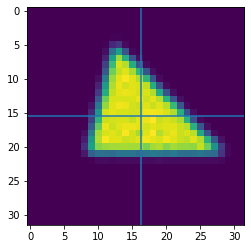


Loading testing data...
Dataset contains 4673 images
Image shape is (32, 32, 1)
Loading images...


  0%|          | 0/4672 [00:00<?, ?it/s]

shuffling
x_test has shape (4673, 32, 32, 1)
y_test has shape (4673, 3, 3)

[[ 0.90821624  0.41850123  0.        ]
 [-0.41850123  0.90821624  0.        ]
 [ 0.          0.          1.        ]]
(16.34532867362054, 15.74342142662365)


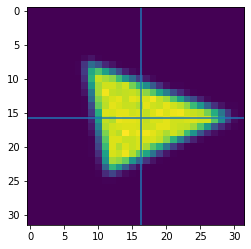


x_data values range from 0.0 to 1.0

training_data = DataLoader(dataset_dir='scalene_triangle_0_355_step5_randomdisp_5000randomtest/train', batch_size=16, contains 5760 images)
testing_data = DataLoader(dataset_dir='scalene_triangle_0_355_step5_randomdisp_5000randomtest/test', batch_size=16, contains 4673 images)


In [8]:
random.seed(0)

# determine the original image size programatically
training_dir = os.path.join(DATASET_DIR, "train")
training_imf = os.listdir(training_dir)
ORIGINAL_SHAPE = Image.open(os.path.join(training_dir, training_imf[0])).size

RESIZE_SHAPE = (32, 32) # (x, y)

# Defocusing blur
# Radius is defined in terms of the size ratio to ensure the blurring observed
# by the network is consistent even if the simulation is adjusted
GAUSS_RADIUS = 1 * RESIZE_SHAPE[0]/50 * ORIGINAL_SHAPE[0]/RESIZE_SHAPE[0]

# displace the centre randomly
CENTRE_AUGMENTATIONS = 16
CENTRE_AUGMENTATION_SIGMA = 2 * RESIZE_SHAPE[0]/50

print("Loading training data...")
training_data = DataLoader(os.path.join(DATASET_DIR, "train"), batch_size=16,
                           onload=[
                                   onload_GaussianBlur(GAUSS_RADIUS),
                                   onload_SEMNoise(),
                                   onload_MedianResizeImage(RESIZE_SHAPE),
                                   ],
                           preproc=[
                                    preproc_Normalise(),
                                    preproc_DynamicRange(1.0),
                                    preproc_CentreAug(CENTRE_AUGMENTATION_SIGMA, CENTRE_AUGMENTATIONS),
                           ],
                           aug=[
                                #preproc_LinearAug((0.95, 1.05), (-0.02, 0.02)),
                                preproc_BrightnessAug(0.75, 1.25),
                                preproc_Shuffle(),
                           ]
                           )

print(f"x_data has shape {training_data.xdata.shape}")
print(f"y_data has shape {training_data.ydata.shape}")
print()

im0 = training_data.xdata[0,:,:].reshape(RESIZE_SHAPE).T
Image.fromarray((im0*255).astype("uint8"), "L").save("preprocessed.png")
rot0 = training_data.ydata[0]
plt.imshow(im0)
COM = ndimage.measurements.center_of_mass(im0.T)
plt.axvline(COM[0])
plt.axhline(COM[1])
print(rot0)
print(COM)
plt.show()

print("\nLoading testing data...")
testing_data = DataLoader(os.path.join(DATASET_DIR, "test"), batch_size=16,
                          onload=[
                                   onload_GaussianBlur(GAUSS_RADIUS),
                                   onload_SEMNoise(),
                                   onload_MedianResizeImage(RESIZE_SHAPE),
                                 ],
                          preproc=[
                                   preproc_Normalise(),
                                   preproc_DynamicRange(1.0),
                                   preproc_Centre(),
                                   preproc_Shuffle(),
                                  ],
                          )

print(f"x_test has shape {testing_data.xdata.shape}")
print(f"y_test has shape {testing_data.ydata.shape}")
print()

im1 = testing_data.xdata[1,:,:].reshape(RESIZE_SHAPE).T
rot1 = testing_data.ydata[1]
plt.imshow(im1)
COM = ndimage.measurements.center_of_mass(im1.T)
plt.axvline(COM[0])
plt.axhline(COM[1])
print(rot1)
print(COM)
plt.show()

print(f"\nx_data values range from {np.min(training_data.xdata)} to {np.max(training_data.xdata)}")

print(f"\ntraining_data = {training_data}")
print(f"testing_data = {testing_data}")

[[-0.9396926   0.34202015  0.        ]
 [-0.34202015 -0.9396926   0.        ]
 [ 0.          0.          1.        ]]
(15.41769199906094, 17.557279169624625)


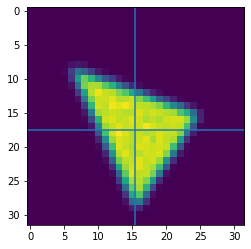

In [9]:
i = 0
im = training_data[i][0][0].reshape(RESIZE_SHAPE).T
rot = training_data[i][1][0]
plt.imshow(im)
COM = ndimage.measurements.center_of_mass(im.T)
plt.axvline(COM[0])
plt.axhline(COM[1])
print(rot)
print(COM)
plt.show()

## pim = Image.fromarray((im0).astype("uint8"), "L")
## pim_mean = onload_MeanResizeImage((32,32))(pim.copy())
## pim_median = onload_MedianResizeImage((32,32))(pim.copy())

## pim.save("original.png")
## pim.save("mean.png")
## pim.save("median.png")

## plt.imshow(np.array(pim))
## plt.show()
## plt.imshow(np.array(pim_mean))
## plt.show()
## plt.imshow(np.array(pim_median))
## plt.show()

# Construct Network

In [46]:
batch_size = training_data.batch_size
epochs = 100

model = keras.Sequential([
                          layers.InputLayer(input_shape=training_data.input_shape),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Flatten(),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(256, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(np.prod(D6_SHAPE), activation="tanh"),
                          layers.Reshape(D6_SHAPE),
                          D6Convert(),
])
model.summary()
# possible new optimizer: keras.optimizers.SGD(learning_rate=0.007, momentum=0.1)
model.compile(optimizer="sgd", loss="mean_squared_error", metrics=["accuracy"])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1152)              0         
                                                                 
 dense_24 (Dense)            (None, 64)               

# Train Model

In [47]:
from matplotlib import gridspec
import time

VALIDATION_FRACTION = 0.1

def choose_validation(n, x, y):
  """Choose n items at random from both arrays, maintaining the same order in both.
  Items will not be duplicated."""
  x_out = np.empty((n,)+x.shape[1:], dtype=x.dtype)
  y_out = np.empty((n,)+y.shape[1:], dtype=y.dtype)

  indices = random.sample(range(n), n)
  for i, j in enumerate(indices):
    x_out[i] = x[j]
    y_out[i] = y[j]
  return x_out, y_out

x_val, y_val = choose_validation(int(testing_data.xdata.shape[0]*VALIDATION_FRACTION), testing_data.xdata, testing_data.ydata)

start_time = time.time()
history = model.fit(
    training_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    #steps_per_epoch=int(np.ceil(training_data.xdata.shape[0]/batch_size)),
    #shuffle=True,
)
end_time = time.time()
print("Training time:", end_time-start_time, "seconds")

Epoch 1/100
360/360 [==============================] - 4s 8ms/step - loss: 0.4700 - accuracy: 0.5222 - val_loss: 0.4688 - val_accuracy: 0.4897
shuffling
Epoch 2/100
360/360 [==============================] - 3s 7ms/step - loss: 0.4475 - accuracy: 0.5412 - val_loss: 0.4498 - val_accuracy: 0.5567
shuffling
Epoch 3/100
360/360 [==============================] - 2s 7ms/step - loss: 0.4422 - accuracy: 0.5382 - val_loss: 0.4235 - val_accuracy: 0.5553
shuffling
Epoch 4/100
360/360 [==============================] - 2s 7ms/step - loss: 0.4337 - accuracy: 0.5478 - val_loss: 0.4455 - val_accuracy: 0.5032
shuffling
Epoch 5/100
360/360 [==============================] - 2s 7ms/step - loss: 0.3967 - accuracy: 0.5698 - val_loss: 0.2977 - val_accuracy: 0.6674
shuffling
Epoch 6/100
360/360 [==============================] - 2s 7ms/step - loss: 0.3242 - accuracy: 0.6406 - val_loss: 0.3919 - val_accuracy: 0.6031
shuffling
Epoch 7/100
360/360 [==============================] - 2s 7ms/step - loss: 0.1066 

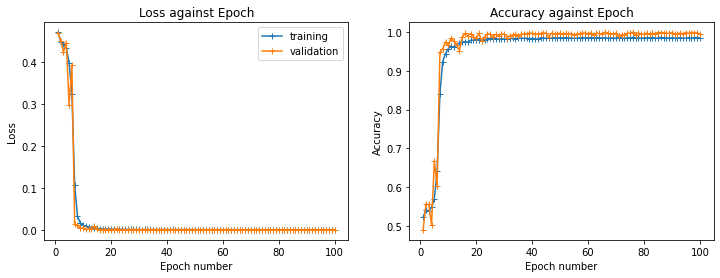

In [48]:
plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*2, plt.rcParams['figure.figsize'][1]))
gs = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0])
ax.plot([i for i in range(1, len(history.history["loss"])+1)], history.history["loss"], "+-", label="training")
ax.plot([i for i in range(1, len(history.history["val_loss"])+1)], history.history["val_loss"], "+-", label="validation")
ax.legend()
ax.set_xlabel("Epoch number")
ax.set_ylabel("Loss")
ax.set_title("Loss against Epoch")

ax = plt.subplot(gs[1])
ax.plot([i for i in range(1, len(history.history["accuracy"])+1)], history.history["accuracy"], "+-", label="training")
ax.plot([i for i in range(1, len(history.history["val_accuracy"])+1)], history.history["val_accuracy"], "+-", label="validation")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy against Epoch")

plt.savefig("training.pdf")
plt.show()

# Test Model

In [49]:
score = model.evaluate(testing_data, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.00023784268705639988
Test accuracy: 0.9909389019012451


In [50]:
i = 6
x_test = testing_data.xdata
y_test = testing_data.ydata

print("True SO(3):\n", y_test[i].astype("float32"), end="\n\n", sep="")
prediction = model.predict(x_test[i].reshape((1,)+x_test[i].shape))[0]
print("SO(3) Prediction:\n", prediction, sep="")
print("Distance: {:.2f} degrees".format(SO3_distance(y_test[i], prediction)))

True SO(3):
[[-0.9986748   0.05146447  0.        ]
 [-0.05146447 -0.9986748   0.        ]
 [ 0.          0.          1.        ]]

SO(3) Prediction:
[[-0.9985476   0.05383731 -0.00203302]
 [-0.05383394 -0.99854845 -0.00167799]
 [-0.00212041 -0.00156611  0.9999964 ]]
Distance: 0.20 degrees


# Analyse Results

In [51]:
MULTI_RUN_MODE = True
if not MULTI_RUN_MODE or "RUN_COUNT" not in globals():
  RUN_COUNT = 0

d = np.zeros(x_test.shape[0])
predictions = model.predict(x_test)
for i in tqdm(range(x_test.shape[0])):
  d[i] = SO3_distance(y_test[i], predictions[i])

if not MULTI_RUN_MODE or "distances" not in globals():
  distances = d
else:
  distances = np.append(distances, d, axis=0)
RUN_COUNT += 1

  0%|          | 0/4673 [00:00<?, ?it/s]

## Plot Histogram

Mean distance from the true value is 1.36 +- 0.89
Median distance: 1.16
This is averaged over 5 run(s).
(run count prediction from number of distances: 5.0)
Max probability at: 0.5717770350673095


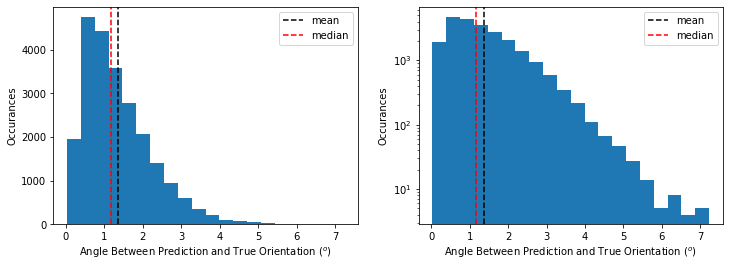

In [52]:
import scipy.stats
from scipy.optimize import curve_fit

def skewed_norm(x, mu, sigma, alpha):
  norm = scipy.stats.norm(loc=mu, scale=sigma)
  return 2*norm.pdf(x)*norm.cdf(alpha*x)

distance_mean = np.mean(distances)
distance_std = np.std(distances, ddof=1)
distance_median = np.median(distances)
print(f"Mean distance from the true value is {distance_mean:.2f} +- {distance_std:.2f}")
print(f"Median distance: {distance_median:.2f}")
print(f"This is averaged over {RUN_COUNT} run(s).")
print(f"(run count prediction from number of distances: {distances.shape[0]/x_test.shape[0]})")

plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*2, plt.rcParams['figure.figsize'][1]))
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0])
hist1 = ax.hist(distances, bins=20)
hist_x = (hist1[1][1:] + hist1[1][:-1]) / 2
ax.axvline(distance_mean, color="k", linestyle="--", label="mean")
ax.axvline(distance_median, color="r", linestyle="--", label="median")
##ax.axvline(hist_x[hist1[0].argmax()], color="r", linestyle="-")
ax.set_xlabel("Angle Between Prediction and True Orientation ($^o$)")
ax.set_ylabel("Occurances")
ax.legend()
print("Max probability at:", hist_x[hist1[0].argmax()])

# fit histogram to skewed Gaussian (actually doesn't match)
## hist_x = hist1[1][:-1]
##popt, pcov = curve_fit(skewed_norm, hist_x, hist1[0], p0=[distance_mean, distance_std, 0])
##print(popt)
##xdata = np.linspace(hist_x.min(), hist_x.max())
##ydata = skewed_norm(xdata, *popt)
##ax.plot(xdata, ydata, "-")

ax = plt.subplot(gs[1])
ax.hist(distances, bins=20, log="y")
ax.axvline(distance_mean, color="k", linestyle="--", label="mean")
ax.axvline(distance_median, color="r", linestyle="--", label="median")
ax.set_xlabel("Angle Between Prediction and True Orientation ($^o$)")
ax.set_ylabel("Occurances")
ax.legend()

plt.savefig("error_hist.pdf")
plt.show()

## Plot Average Error Distribution with Angle

In [53]:
angles = np.zeros((y_test.shape[0],), dtype=y_test.dtype)
for i in tqdm(range(y_test.shape[0])):
  angles[i] = np.rad2deg(R.from_matrix(y_test[i]).as_euler("zyx"))[0]
angles[angles < 0] += 360
print(angles.min(), angles.max())
# duplicate by number of runs
angles = np.stack((angles,) * RUN_COUNT, axis=0).flatten()

SPACING = 5
categories = np.linspace(0, SPACING/2, num=6)
closest_indices = np.zeros(angles.shape, dtype=np.int)
for i in tqdm(range(angles.shape[0])):
  closest_indices[i] = np.abs(categories - angles[i]%(SPACING/2)).argmin()
average_distances = np.zeros(categories.shape, dtype=distances.dtype)
for i, category in enumerate(categories):
  category_distances = distances[closest_indices == i]
  average_distances[i] = np.sum(category_distances)/category_distances.shape[0]

  0%|          | 0/4673 [00:00<?, ?it/s]

0.23 359.96


  0%|          | 0/23365 [00:00<?, ?it/s]

  0%|          | 0/23365 [00:00<?, ?it/s]

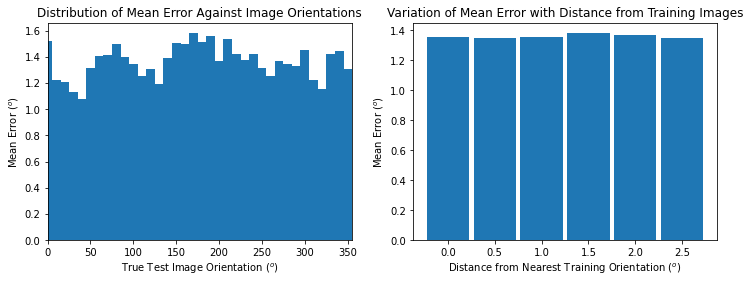

In [54]:
full_categories = np.linspace(0, 360, num=36, endpoint=False)
full_closest_indices = np.zeros(angles.shape, dtype=np.int)
for i in tqdm(range(angles.shape[0])):
  full_closest_indices[i] = np.abs(full_categories - angles[i]).argmin()
full_average_distances = np.zeros(full_categories.shape, dtype=distances.dtype)
for i, category in enumerate(full_categories):
  full_category_distances = distances[full_closest_indices == i]
  full_average_distances[i] = np.sum(full_category_distances)/full_category_distances.shape[0]

plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*2, plt.rcParams['figure.figsize'][1]))
gs = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0])
ax.bar(full_categories, full_average_distances, width=(360)/(full_categories.shape[0]-1))
ax.set_xlabel("True Test Image Orientation ($^o$)")
ax.set_ylabel("Mean Error ($^o$)")
ax.set_title("Distribution of Mean Error Against Image Orientations")
ax.set_xlim(0, 355)

ax = plt.subplot(gs[1])
ax.bar(categories, average_distances, width=(SPACING/2)/(categories.shape[0]-1)-0.05)
ax.set_xlabel("Distance from Nearest Training Orientation ($^o$)")
ax.set_ylabel("Mean Error ($^o$)")
ax.set_title("Variation of Mean Error with Distance from Training Images")

plt.savefig("angular_error_hist.pdf")
plt.show()